In [ ]:
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
    

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
)

import numpy as np
import tensorflow as tf
import torch
from datasets import Dataset, load_dataset, DatasetDict


import pandas as pd


In [ ]:
dataset_url = "hf://datasets/ESGBERT/environmental_2k/environmental_2k.csv"
model_checkpoint = "google/bert_uncased_L-2_H-512_A-8"

"""Other models to try:
distilbert-base-uncased
"""

train_ratio = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)


using device:  cuda


In [ ]:

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
mlm_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/91.0M [00:00<?, ?B/s]

In [ ]:
tokenizer

BertTokenizerFast(name_or_path='google/bert_uncased_L-2_H-512_A-8', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
"""sample model pipeline"""
sample = "test [MASK] some [MASK]thin [MASK]"

# Tokenize text
sample_tokenized = tokenizer([sample], return_tensors='pt', padding=True)
samp_out = mlm_model(**sample_tokenized)

print("output logits: ", samp_out.logits)

output logits:  tensor([[[ -9.4125,  -8.4637,  -9.1380,  ...,  -8.2152, -11.9307,  -7.7812],
         [ -9.7084,  -8.3756,  -8.8134,  ...,  -7.9416, -10.9808,  -8.9557],
         [ -8.2224,  -8.2958,  -7.6333,  ...,  -7.0930, -10.0589,  -4.0423],
         ...,
         [-10.0483, -10.6377,  -9.6757,  ...,  -8.6886, -10.9759,  -9.4402],
         [ -7.4171,  -9.1206,  -7.7921,  ...,  -8.2052,  -8.1394,  -6.1813],
         [ -8.9019,  -8.2693,  -7.9525,  ...,  -7.9172, -11.5575,  -7.4230]]],
       grad_fn=<ViewBackward0>)


In [ ]:
text = "This is a great [MASK]."


inputs = tokenizer(text, return_tensors="pt")
token_logits = mlm_model(**inputs).logits

# Find the location of [MASK] and extract its logits
mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[1, 0]
mask_token_logits = token_logits[0, mask_token_index, :]

# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.argsort(mask_token_logits, descending=True)[:5].tolist()

for token in top_5_tokens:
    print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

>>> This is a great event.
>>> This is a great place.
>>> This is a great idea.
>>> This is a great thing.
>>> This is a great deal.


In [ ]:
"""Read environment dataset from ESGBERT (2k labelled samples) from huggingface"""
df = pd.read_csv(dataset_url)[['text', 'env']]
df['env'] = df['env'].astype('int16')

In [ ]:
"""Arrow Dataset"""
class EnvDataset(Dataset):
    """ESG dataset."""
    def __init__(self, df:pd.DataFrame):
        """
        Arguments:
            df (Dataframe): dataframe to construct dataset from
        """
        self.df_dict=df.to_dict(orient='list')
        self.len = len(df.index)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return {
                k : v[idx] for k, v in self.df_dict.items()
            }

In [ ]:
ds = Dataset.from_pandas(df)
dataset = ds.train_test_split(train_size=train_ratio)

In [ ]:
samp = dataset['train'].shuffle().select(range(5))
for row in samp:
    print(f"txt: {row['text']}, \nlabel: {row['env']}")

txt: – Our environmental management system provides a framework to help us oversee our environmental responsibilities effectively and meet our targets., 
label: 1
txt: Public Lands Media continued reporting on topics critical to the preservation of public lands, such as wildfire ecology, livestock grazing, and forest service policies., 
label: 1
txt: In some geographies there is limited data and incomplete historical monitoring, and so the model is enhanced using simulated events set to forecast the impact of projected climate perils., 
label: 1
txt: To help our customers reduce their COanother key target of our 2030 sustainability strategy – we have identified products and solutions from our portfolio that deliver the most significant reductions in CO2 emissions., 
label: 1
txt: This statement focuses on the material risks and uncertainties that the Group's Management Board and the Board of Directors currently consider to be relevant to the Group.  , 
label: 0


In [ ]:
"""Input Preprocessing"""

# Tokenizing function
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Process labels to make them multi-class (2 classes) for use of cross-entropy loss
def tupelize_labels(examples):
    result = examples
    result['label'] = [[val, 1-val] for val in examples['env']]
    return result

# Map transformations over datasets. Use batched=True to activate multithreading

# Prepare dataset for mlm pretraining--this only requires tokenized input text and the masked input ids and locations for labels
tokenized_datadict_for_mlm = dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "env"]
)

tokenized_dataset_classification = dataset.map(
    tokenize_function, batched=True, remove_columns=["text"]
)

tokenized_dataset_classification = tokenized_dataset_classification.map(
    tupelize_labels, batched=True
)

tokenized_datadict_for_mlm

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 400
    })
})

In [ ]:
"""View train dataset"""
pd.DataFrame(tokenized_datadict_for_mlm['train']).head()

,input_ids,token_type_ids,attention_mask,word_ids
0,"[101, 6643, 2063, 1041, 1004, 1052, 11645, 313...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[None, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11..."
1,"[101, 2256, 5126, 9002, 2007, 2037, 3167, 8147...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."
2,"[101, 2057, 2031, 1037, 2844, 3579, 2006, 2731...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."
3,"[101, 1031, 2116, 2047, 4353, 16910, 2020, 939...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 6, 7, 8, 9, 10, 11..."
4,"[101, 2057, 2024, 5462, 2000, 7694, 1037, 3647...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."


<Axes: >

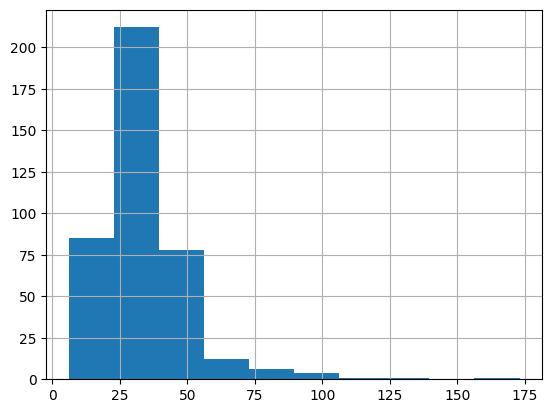

In [ ]:
"""Analyse distribution of token lengths for setences in the dataset"""
tst = pd.DataFrame(tokenized_datadict_for_mlm['test'])['input_ids'].apply(len)
tst.hist()

In [ ]:
"""Further data processing: group setnences into one long setnence and split into chunk-sized sentences"""
def get_stacked_dataset(dataset:Dataset, separator_tok=None, chunk_size=256):
    dataset_dict = dataset.to_dict() if isinstance(dataset, Dataset) else dataset
    stacked_len = len(np.hstack(dataset_dict[list(dataset_dict.keys())[0]]))
    dataset_dict = {
        k:np.hsplit(np.hstack(dataset_dict[k])[:-(stacked_len%chunk_size)], stacked_len//chunk_size) for k in dataset_dict
    } if separator_tok else {
        k:np.hsplit(np.hstack(dataset_dict[k])[:-(stacked_len%chunk_size)], stacked_len//chunk_size) for k in dataset_dict
    }
    dataset_dict['labels'] = dataset_dict['input_ids'].copy()
    return Dataset.from_dict(dataset_dict) if isinstance(dataset, Dataset) else dataset_dict

test = get_stacked_dataset(dataset=tokenized_datadict_for_mlm['test'])
len(test[-1]['input_ids'])


256

In [ ]:
"""Final dataset that we will be using to train and evaluate our model"""
tokenized_chunked_datadict = tokenized_datadict_for_mlm.map(get_stacked_dataset, batched=True)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
"""Brief check of a sample's token length"""
print("token-length of a sentence: ", len(tokenized_chunked_datadict["train"][0]["input_ids"]))
tokenized_chunked_datadict

token-length of a sentence:  256


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 212
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 53
    })
})

In [ ]:
from transformers import DataCollatorForLanguageModeling, DataCollatorForWholeWordMask, DefaultDataCollator, DataCollatorWithPadding#DataCollatorForSe

"""
Data collation--default functions that prepare our data into batches for training. They also
do additional tasks like word masking (for mlm objective) and padding
"""
mask_probability = 0.15

# Simple data collator for MLM objective (masks each token with given probability)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=mask_probability)

# Whole word masking (masks each word with given probability)
data_collator_wwm = DataCollatorForWholeWordMask(tokenizer=tokenizer, mlm_probability=mask_probability)

# Simple collator for our classification task (after pretraining)--just pads and batches input
data_collator_classification = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

In [ ]:
"""Sample data collating inputs and labels"""
example_batch_size = 2
samples = [tokenized_chunked_datadict["train"][i] for i in range(example_batch_size)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator_wwm(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")
for chunk in data_collator_wwm(samples)["labels"]:
    print(f"\n'>>> {chunk}'")


'>>> [CLS] pae e & [MASK] bolivia limited ordinary [MASK] american energy investments [MASK]. [SEP] [CLS] our employees [MASK] with their personal engagement significantly to [MASK] success of [MASK] bank. [SEP] [CLS] we have a strong focus on training and developing our people to [MASK] them reach their potential [MASK] their job and [MASK]. [SEP] [CLS] [ many new distribution pathways were validated that provide greater opportunity [MASK] utilise ocean freight, [MASK] into the emerging middle eastern markets [MASK] ] [SEP] [CLS] we are committed to promoting a [MASK] and healthy working environment, where employees are treated fairly [MASK] with respect [MASK] [MASK] where they can reach their [MASK] [MASK]. [SEP] [CLS] our commitment to fair [MASK] and sustainable sourcing [MASK] demonstrated by our membership of the fairtrade foundation, and our [MASK] of the ethical trading initiative. [SEP] [CLS] e natural gas liquids for russia are included in [MASK] [MASK]. [SEP] [CLS] use of 

In [ ]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(tokenized_chunked_datadict["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=False,
    use_cpu=(device==torch.device('cpu')),
    # fp16=True, # on gpu ..
    logging_steps=logging_steps,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer_mlm = Trainer(
    model=mlm_model,
    args=training_args,
    train_dataset=tokenized_chunked_datadict["train"],
    eval_dataset=tokenized_chunked_datadict["test"],
    data_collator=data_collator_wwm, # experiment with the other data collator for masked language modelling
    tokenizer=tokenizer,
)

In [ ]:
"""Compute perplexity of model (prior to pretraining; this is just the BERT model checkpoint trained on natural language english)"""
import math

eval_results = trainer_mlm.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 29.82


In [ ]:
"""train model"""
trainer_mlm.train()

'train model'

In [ ]:
"""Evaluate perplexity again after training--is there an improvement?"""
eval_results = trainer_mlm.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 30.80


In [ ]:
# view model config
print(mlm_model.config)

# Save model (this is not the complete classifier, just the pretrained MLM model) FIXME uncomment save line for trying
mlm_model_dirname = f'saved_mlm_models/finetuned-{mlm_model.config.name_or_path.replace("google/", "")}'
# mlm_model.save_pretrained(mlm_model_dirname)

BertConfig {
  "_name_or_path": "google/bert_uncased_L-2_H-512_A-8",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
"""loading model and retreiving basemodel (encoder, without MLM head)"""
"""If loading saved model, uncomment"""
# loaded_mlm_model = AutoModelForMaskedLM.from_pretrained(mlm_model_dirname)
# base_model = loaded_model.base_model

base_model = mlm_model.base_model


In [ ]:
class BertClassifier(torch.nn.Module):
    def __init__(self, base_bert_model, num_classes=2):
        super(BertClassifier, self).__init__()

        # The base (pre-trained) bert encoder
        self.base_model = base_bert_model

        # Custom classification head
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(self.base_model.config.max_position_embeddings, num_classes) # output features from bert is 512 and 2 is ur number of labels

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask)

        outputs = self.dropout(outputs.last_hidden_state[:,0,:]) # This returns the last hidden state of the token corresponding to [CLS] (see BERT paper)
        outputs = self.linear(outputs)

        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(outputs.float(), labels.float())
            print("loss: ", loss)

        return (loss, outputs) if labels is not None else (outputs,)


In [ ]:
classifier_model = BertClassifier(base_bert_model=mlm_model.base_model)
classifier_model

BertClassifier(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elemen

In [ ]:
import numpy as np
import evaluate
from datasets import Value

metric = evaluate.load("accuracy")

# for accuracy:
def compute_metrics(eval_pred):
    labels, logits = eval_pred
    predictions = np.argmax(logits, axis=1)#torch.softmax(torch.tensor(logits).float(), dim=1)  #np.argmax(logits, axis=1)
    references = np.argmax(labels, axis=1)

    return metric.compute(predictions=(predictions), references=references)#(labels))

training_args_classifier = TrainingArguments(output_dir="train_out", eval_strategy="epoch", use_cpu=(device==torch.device('cpu')))
trainer_classifier = Trainer(
    model=classifier_model,
    args=training_args_classifier,
    train_dataset=tokenized_dataset_classification['train'],
    eval_dataset=tokenized_dataset_classification['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator_classification,
)



In [ ]:
"""Testing evaluate, before training the (randomly initialized) classification head"""
trainer_classifier.evaluate()

loss:  tensor(0.6582, device='cuda:0')


loss:  tensor(0.7364, device='cuda:0')
loss:  tensor(0.6770, device='cuda:0')
loss:  tensor(0.6506, device='cuda:0')
loss:  tensor(0.7915, device='cuda:0')
loss:  tensor(0.7300, device='cuda:0')
loss:  tensor(0.6636, device='cuda:0')
loss:  tensor(0.6357, device='cuda:0')
loss:  tensor(0.6365, device='cuda:0')
loss:  tensor(0.6853, device='cuda:0')
loss:  tensor(0.6593, device='cuda:0')
loss:  tensor(0.7300, device='cuda:0')
loss:  tensor(0.8192, device='cuda:0')
loss:  tensor(0.6747, device='cuda:0')
loss:  tensor(0.5955, device='cuda:0')
loss:  tensor(0.5514, device='cuda:0')
loss:  tensor(0.6873, device='cuda:0')
loss:  tensor(0.7189, device='cuda:0')
loss:  tensor(0.5560, device='cuda:0')
loss:  tensor(0.5789, device='cuda:0')
loss:  tensor(0.7371, device='cuda:0')
loss:  tensor(0.6784, device='cuda:0')
loss:  tensor(0.7771, device='cuda:0')
loss:  tensor(0.6574, device='cuda:0')
loss:  tensor(0.6463, device='cuda:0')
loss:  tensor(0.7299, device='cuda:0')
loss:  tensor(0.6934, dev

{'eval_loss': 0.6852952837944031,
 'eval_accuracy': 0.5325,
 'eval_runtime': 1.7812,
 'eval_samples_per_second': 224.563,
 'eval_steps_per_second': 28.07}

In [ ]:
trainer_classifier.train()

loss:  tensor(0.6856, device='cuda:0', grad_fn=<DivBackward1>)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.225425,0.927500
2,No log,0.234540,0.942500
3,0.244000,0.255887,0.937500


loss:  tensor(0.6606, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4413, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7301, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7089, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.3245, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.3121, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.9461, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.2447, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.2328, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4028, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(1.1116, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(1.4247, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7310, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.3727, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.6618, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4743, device='cuda:0', grad_fn=<DivBack

loss:  tensor(0.0533, device='cuda:0')
loss:  tensor(0.0169, device='cuda:0')
loss:  tensor(0.0637, device='cuda:0')
loss:  tensor(0.0056, device='cuda:0')
loss:  tensor(0.0646, device='cuda:0')
loss:  tensor(0.4878, device='cuda:0')
loss:  tensor(0.1867, device='cuda:0')
loss:  tensor(0.0070, device='cuda:0')
loss:  tensor(0.0370, device='cuda:0')
loss:  tensor(0.0028, device='cuda:0')
loss:  tensor(0.3342, device='cuda:0')
loss:  tensor(0.0330, device='cuda:0')
loss:  tensor(0.0174, device='cuda:0')
loss:  tensor(0.3381, device='cuda:0')
loss:  tensor(0.4508, device='cuda:0')
loss:  tensor(1.0549, device='cuda:0')
loss:  tensor(0.6642, device='cuda:0')
loss:  tensor(0.1714, device='cuda:0')
loss:  tensor(0.2806, device='cuda:0')
loss:  tensor(0.7142, device='cuda:0')
loss:  tensor(0.0082, device='cuda:0')
loss:  tensor(0.1447, device='cuda:0')
loss:  tensor(0.8699, device='cuda:0')
loss:  tensor(0.0324, device='cuda:0')
loss:  tensor(0.0038, device='cuda:0')
loss:  tensor(0.1501, dev

TrainOutput(global_step=600, training_loss=0.22315019925435384, metrics={'train_runtime': 20.8044, 'train_samples_per_second': 230.72, 'train_steps_per_second': 28.84, 'total_flos': 0.0, 'train_loss': 0.22315019925435384, 'epoch': 3.0})

In [ ]:
trainer_classifier.evaluate()

loss:  tensor(1.7455, device='cuda:0')


loss:  tensor(0.0095, device='cuda:0')
loss:  tensor(0.0074, device='cuda:0')
loss:  tensor(0.0467, device='cuda:0')
loss:  tensor(0.0016, device='cuda:0')
loss:  tensor(0.0113, device='cuda:0')
loss:  tensor(0.7748, device='cuda:0')
loss:  tensor(0.5851, device='cuda:0')
loss:  tensor(0.0010, device='cuda:0')
loss:  tensor(0.0460, device='cuda:0')
loss:  tensor(0.0005, device='cuda:0')
loss:  tensor(0.6181, device='cuda:0')
loss:  tensor(0.0048, device='cuda:0')
loss:  tensor(0.0017, device='cuda:0')
loss:  tensor(0.4561, device='cuda:0')
loss:  tensor(0.7495, device='cuda:0')
loss:  tensor(0.9666, device='cuda:0')
loss:  tensor(0.9604, device='cuda:0')
loss:  tensor(0.0304, device='cuda:0')
loss:  tensor(0.5290, device='cuda:0')
loss:  tensor(0.8937, device='cuda:0')
loss:  tensor(0.0015, device='cuda:0')
loss:  tensor(0.0271, device='cuda:0')
loss:  tensor(1.1651, device='cuda:0')
loss:  tensor(0.0158, device='cuda:0')
loss:  tensor(0.0005, device='cuda:0')
loss:  tensor(0.1919, dev

{'eval_loss': 0.25588664412498474,
 'eval_accuracy': 0.9375,
 'eval_runtime': 0.3812,
 'eval_samples_per_second': 1049.202,
 'eval_steps_per_second': 131.15,
 'epoch': 3.0}

In [ ]:
def process_model_input_for_inference(input, tokenizer):
    tokenized = tokenizer(input)
    return {'input_ids':torch.tensor([tokenized['input_ids']]).to(device), 'attention_mask':torch.tensor([tokenized['attention_mask']])}





In [ ]:
sample_inputs = ["in the last quarter we upped our social impact by a lot",
                 "in the last quarter we upped our environmental impact by a lot",
                 "some random sentence",
                 "this is related to environmental governence.",
                 'That’s why our strategy looks much more holistically at the health of local watersheds.',
                 'To achieve our commitment, we begin by assessing wages across all operating companies against the Fair Wage Network and aim to close any wage gaps by the end of 2023.',
                 'We are committed to maintaining and enhancing our reputation for responsible business practices and will continue to promote our standards in line with our Business Principles.']

for inp in sample_inputs:
    # Remember model was trained on outputs that look like [1, 0] for 1 and [0, 1] for 0
    print(f'{inp}: {1-np.argmax(classifier_model(**process_model_input_for_inference(inp, tokenizer=tokenizer))[0].detach().cpu().numpy())}')


in the last quarter we upped our social impact by a lot: 0
in the last quarter we upped our environmental impact by a lot: 1
some random sentence: 0
this is related to environmental governence.: 1
That’s why our strategy looks much more holistically at the health of local watersheds.: 1
To achieve our commitment, we begin by assessing wages across all operating companies against the Fair Wage Network and aim to close any wage gaps by the end of 2023.: 0
We are committed to maintaining and enhancing our reputation for responsible business practices and will continue to promote our standards in line with our Business Principles.: 0


In [ ]:
# Save classifier model FIXME uncomment to use
# torch.save(classifier_model, 'saved_classifier_models/my_esg_env_classifier_1')